In [ ]:
%pylab inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


month = '2016-09-01'
sql = """SELECT * FROM (
  SELECT
    month,
    pct,
    pmean,
    p50th,
    DENSE_RANK() OVER (PARTITION BY month ORDER BY pmean ASC) AS p_rank
  FROM (
    SELECT
      month,
      pct,
      MAX(p_count) AS pcount,
      MAX(p_average) AS pmean,
      MAX(p_50th) AS p50th
    FROM (
      SELECT
        month,
        pct,
        COUNT(*) OVER (PARTITION BY month, pct ORDER BY ppq ASC) AS p_count,
        AVG(ppq) OVER (PARTITION BY month, pct) AS p_average,
        PERCENTILE_CONT(0.5) OVER (PARTITION BY month, pct ORDER BY ppq ASC) AS p_50th
      FROM (
        SELECT
          month,
          pct,
          net_cost/quantity AS ppq
        FROM
          [ebmdatalab:hscic.prescribing] AS p
        LEFT JOIN ebmdatalab.hscic.practices practices
          ON p.practice = practices.code
        WHERE
          practices.setting = 4 AND
          bnf_code LIKE '0601060D0%'))
    GROUP BY
      month,
        pct) 
        
ORDER BY
  month, p_rank
)"""
df = pd.io.gbq.read_gbq(
        sql, project_id="ebmdatalab", verbose=False, dialect='legacy')

# Comparing three selected CCGs

In [171]:
interest = df[(df.pct == '99P') | (df.pct == '99F')| (df.pct == '03J')]
interest = interest.set_index('month')

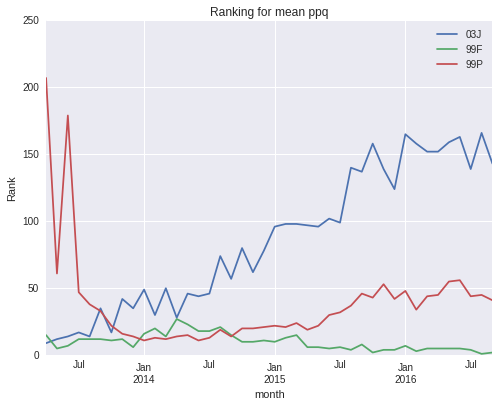

In [168]:

fig, ax = plt.subplots(figsize=(8,6))
for label, sdf in interest.groupby('pct'):
    sdf.p_rank.plot(ax=ax, label=label)
    #sdf.p50th.plot(ax=ax, label=label + "(median)")
    #sdf.pmean.plot(ax=ax, label=label + "(mean)")
plt.legend()
plt.title("Ranking for mean ppq")
ax.set_ylabel("Rank")
plt.show()


#sns.tsplot(interest, time='month', value='p50th', condition='pct')

# Worst performing CCGs

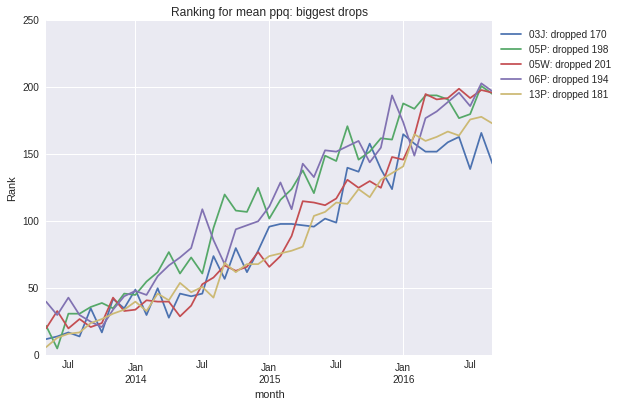

In [166]:
fig, ax = plt.subplots(figsize=(8, 6)) 
ax.set_ylabel("Rank")
recent = df[df.month > '2013-04-01'].reset_index()
for key, grp in recent.groupby('pct'): 
    grp = grp.set_index('month')
    x = np.arange(len(grp))
    y = np.array(grp['p_rank'])
    p, res, _, _, _ = np.polyfit(x, y, 1, full=True)
    m, b = p   
    if res < 10000 and m > 4:
    #if grp['cost'].max() > 1000000 and grp['cost'].max() < 2000000:
        delta = ((m*(len(grp)) - 1) + b) - b
        label = key + ": dropped " + str(int(delta))
        grp.p_rank.plot(ax=ax, label=label)
plt.legend(loc="upper left", bbox_to_anchor=(1,1))   
plt.title("Ranking for mean ppq: biggest drops")
plt.show()

# Best performing CCGs

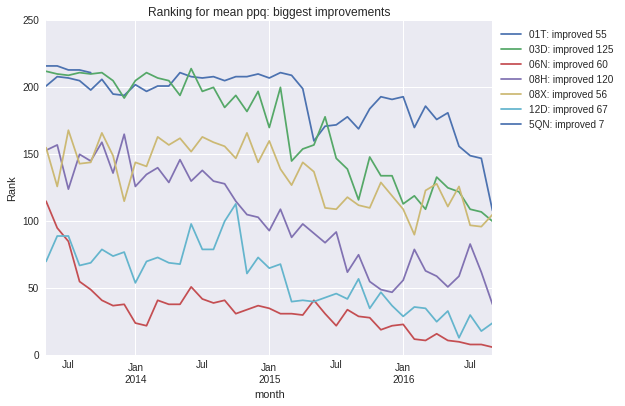

In [170]:
fig, ax = plt.subplots(figsize=(8, 6)) 
ax.set_ylabel("Rank")
for key, grp in recent.groupby('pct'): 
    grp = grp.set_index('month')
    x = np.arange(len(grp))
    y = np.array(grp['p_rank'])
    p, res, _, _, _ = np.polyfit(x, y, 1, full=True)
    m, b = p   
    if res < 10000 and m < -1.3:
    #if grp['cost'].max() > 1000000 and grp['cost'].max() < 2000000:
        delta = ((m*(len(grp)) - 1) + b) - b
        label = key + ": improved " + str(abs(int(delta)))
        grp.p_rank.plot(ax=ax, label=label)
plt.legend(loc="upper left", bbox_to_anchor=(1,1))   
plt.title("Ranking for mean ppq: biggest improvements")
plt.show()